In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.distributions.multivariate_normal import MultivariateNormal

class TorchMultivariateGaussianClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, class_params=None, device="cpu"):
        """
        Initialize the classifier with class parameters.

        Parameters:
        class_params: dict
            A dictionary where keys are class labels and values are dictionaries with
            'mean' (vector), 'cov' (matrix), and 'prior' for each class.
        device: str
            The device to use for computations ('cpu' or 'cuda').
        """
        self.class_params = class_params if class_params is not None else {}
        self.device = torch.device(device)
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
    
    def fit(self, X, y=None):
        """
        Fit method for compatibility. This classifier doesn't require fitting.
        """
        self.classes_ = torch.tensor(list(self.class_params.keys()), device=self.device)
        return self
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for the given input data X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        probs: torch.Tensor of shape (n_samples, n_classes)
            Predicted probabilities for each class.
        """
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, device=self.device, dtype=torch.float32)
        
        probs = torch.zeros((X.shape[0], len(self.classes_)), device=self.device)
        for i, c in enumerate(self.classes_):
            mean = torch.tensor(self.class_params[int(c)]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(c)]["cov"], device=self.device, dtype=torch.float32)
            prior = self.class_params[int(c)]["prior"]
            
            # Multivariate normal distribution
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            px_given_y = torch.exp(mvn_dist.log_prob(X))
            
            # Combine with prior
            probs[:, i] = px_given_y * prior
        
        # Normalize to get P(y=c|x)
        probs /= probs.sum(dim=1, keepdim=True)
        return probs
    
    def predict(self, X):
        """
        Predict the class label for each sample in X.

        Parameters:
        X: torch.Tensor or array-like of shape (n_samples, n_features)
            Input features.

        Returns:
        predictions: torch.Tensor of shape (n_samples,)
            Predicted class labels.
        """
        probs = self.predict_proba(X)
        return self.classes_[torch.argmax(probs, dim=1)]
    
    def generate_data(self, n_samples=100):
        """
        Generate synthetic data using the predefined class parameters.

        Parameters:
        n_samples: int
            Number of samples to generate.

        Returns:
        X: torch.Tensor of shape (n_samples, n_features)
            Generated features.
        y: torch.Tensor of shape (n_samples,)
            Generated labels.
        """
        X = []
        y = []
        for _ in range(n_samples):
            # Sample class based on priors
            sampled_class = torch.multinomial(
                torch.tensor([self.class_params[int(c)]["prior"] for c in self.classes_], device=self.device),
                num_samples=1
            ).item()
            mean = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["mean"], device=self.device, dtype=torch.float32)
            cov = torch.tensor(self.class_params[int(self.classes_[sampled_class])]["cov"], device=self.device, dtype=torch.float32)
            
            # Sample feature vector from the corresponding multivariate Gaussian
            mvn_dist = MultivariateNormal(mean, covariance_matrix=cov)
            sampled_x = mvn_dist.sample()
            X.append(sampled_x)
            y.append(self.classes_[sampled_class].item())
        
        return torch.stack(X), torch.tensor(y, device=self.device)


In [2]:
from torchcp.classification.score import APS, THR
aps = APS(score_type="identity", randomized=False)
lac = THR(score_type="identity",)
score = aps

/home/jonas/anaconda3/envs/plnet/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class OracleAnnotator:
    def __init__(self,score, generator):
        self.score = score
        self.classes_ = generator.classes_
        self.generator = generator


    def generate_pairs_cross_instance(self, n):
        """
        Generates synthetic data and labels based on the learned model and feature distribution.
        
        Returns:
        - X_synthetic (ndarray): Generated feature matrix of shape (n_samples, n_features).
        - y_synthetic (ndarray): Generated labels of shape (n_samples,).
        """        
        # Generate synthetic features based on the inferred distribution
        
        X = self.generator.generate_instances(2*n)
        y = np.random.choice(self.classes_, size=2*n, replace=True)
        conformities = self.get_conformity(X,y)

        X_rs = X.reshape(n,2,self.generator.n_features_)
        y_rs = y.reshape(n,2)
        conformities_n_rs = - conformities.reshape(n,2)
        sort_idx = conformities_n_rs.argsort(axis=1)
        X_rs[sort_idx]
        y_rs[sort_idx,:]
        X_pairs = np.take_along_axis(X_rs, sort_idx[:, :, np.newaxis], axis=1)
        y_pairs = np.expand_dims(np.take_along_axis(y_rs, sort_idx, axis=1),axis=-1)

        return X_pairs, y_pairs
    
    # we assume y is already label encoded
    def get_conformity(self, X, y):
        y_pred_proba = self.generator.predict_proba(X)
        scores = self.score(y_pred_proba, y)
        return scores

In [4]:
# Initialize and fit the generator
class_params = {
    0: {
        "mean": [3.0, 2.0, 1.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 4.0, 4.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}



clf = TorchMultivariateGaussianClassifier(class_params=class_params, device="cpu")
X, y = clf.generate_data(n_samples=1000)



In [5]:
X_train = X.repeat_interleave(3, dim=0)
X_train

tensor([[3.6383, 1.2640, 1.0551],
        [3.6383, 1.2640, 1.0551],
        [3.6383, 1.2640, 1.0551],
        ...,
        [1.0122, 4.7659, 4.7688],
        [1.0122, 4.7659, 4.7688],
        [1.0122, 4.7659, 4.7688]])

In [6]:
def goodman_kruskal_gamma(x, y):
    """
    Compute Goodman and Kruskal's Gamma for two ordinal variables.
    
    Parameters:
    x, y: Lists or arrays of ordinal data (same length)
    
    Returns:
    gamma: Goodman and Kruskal's Gamma
    """
    if len(x) != len(y):
        raise ValueError("Both variables must have the same length.")
    
    concordant = 0
    discordant = 0
    
    n = len(x)
    for i in range(n - 1):
        for j in range(i + 1, n):
            # Determine concordance or discordance
            if (x[i] > x[j] and y[i] > y[j]) or (x[i] < x[j] and y[i] < y[j]):
                concordant += 1
            elif (x[i] > x[j] and y[i] < y[j]) or (x[i] < x[j] and y[i] > y[j]):
                discordant += 1
    
    # Compute Gamma
    if concordant + discordant == 0:
        return 0  # Avoid division by zero
    gamma = (concordant - discordant) / (concordant + discordant)
    return gamma

In [77]:
from mapie.classification import MapieClassifier
from mapie.conformity_scores.sets import APSConformityScore, LACConformityScore, NaiveConformityScore, TopKConformityScore
from util.ranking_datasets import LabelPairDataset
from models.ranking_models import LabelRankingModel
from torch.utils.data.dataloader import DataLoader
from sklearn.datasets import make_classification
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
from models.ranking_models import SortLayer
import torch

def conduct_oracle_experiment(score, num_instances_to_check, generator, X_cal, y_cal):
    tau_corrs = []
    gamma_corrs = []
    # Generate a small dataset
    # create 
    oracle_annotator = OracleAnnotator(generator=generator, score=score)
    models = []

    for num_instances in num_instances_to_check:
        X_gen, _ = generator.generate_data(n_samples=num_instances)
        X_train = X_gen.repeat_interleave(3, dim=0)
        y_train = np.tile(generator.classes_, num_instances)
        conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()
        sort_idx = (-conformities).argsort(axis=0).flatten()
        X_sorted = X_train[sort_idx]
        y_sorted = y_train[sort_idx]

        
        X_pairs = np.array([(X_sorted[i], X_sorted[j]) for i in range(len(X_sorted)) for j in range(i + 1, len(X_sorted))])
        y_pairs = np.array([(y_sorted[i], y_sorted[j]) for i in range(len(y_sorted)) for j in range(i + 1, len(y_sorted))])
        y_pairs = np.expand_dims(y_pairs,axis=-1)


        ds = LabelPairDataset()
        ds.create_from_numpy_pairs(X_pairs, y_pairs)
        pair_loader = DataLoader(ds, batch_size=64)
        ds_val = LabelPairDataset()
        ds_val.create_from_numpy_pairs(X_pairs, y_pairs)
        val_loader = DataLoader(ds_val, batch_size=64)
        model = LabelRankingModel(input_dim=3, hidden_dims=2*[6], activations=[torch.nn.Sigmoid(), torch.nn.Sigmoid(), torch.nn.Sigmoid()], output_dim=len(generator.classes_))
        model.num_classes = 3
        device = next(model.parameters()).device
        model._fit(pair_loader, val_loader=pair_loader, num_epochs=200, learning_rate=0.001, patience=200, verbose=True)

        # generate data from data generating process and check whether the learned non-conformity relation sorts them correctly
        X_test, y_test = generator.generate_data(n_samples=100)
        # X_test = X_gen.repeat_interleave(3, dim=0)
        # y_test = np.tile(generator.classes_, 100)
        skills_from_model = np.take_along_axis(model.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
        conformity_scores = oracle_annotator.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
        tau_corr, p_value = kendalltau(skills_from_model, conformity_scores)
        tau_corrs.append(tau_corr)
        gamma_corr = goodman_kruskal_gamma(skills_from_model,conformity_scores)
        gamma_corrs.append(gamma_corr)
        models.append(model)
    return tau_corrs, gamma_corrs, skills_from_model, conformity_scores, models

In [78]:
num_instances_to_check = np.linspace(10,100,3).astype(int)
X_train, y_train = make_classification(
    n_samples=100, n_features=3, n_classes=3, n_informative=3, n_redundant=0, n_repeated=0, n_clusters_per_class=1, random_state=42
)
# Initialize and fit the generator
class_params = {
    0: {
        "mean": [3.0, 2.0, 1.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 4.0, 4.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


clf = TorchMultivariateGaussianClassifier(class_params=class_params, device="cpu")
clf.fit(X_train, y_train)
X_cal, y_cal = clf.generate_data(n_samples=100)
num_instances_to_check = [150]
tau_corrs_LAC, gamma_corrs_LAC, skills_LAC, conformities_LAC, models_LAC = conduct_oracle_experiment(lac, num_instances_to_check, clf, X_cal, y_cal)
tau_corrs_APS, gamma_corrs_APS, skills_APS, conformities_APS, models_APS = conduct_oracle_experiment(aps, num_instances_to_check, clf, X_cal, y_cal)

/tmp/ipykernel_116313/1949202213.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformities = oracle_annotator.get_conformity(torch.tensor(X_train),torch.tensor(y_train)).detach().numpy()


Epoch 1/200
  Train Loss: 0.0004
  Val Loss: 0.0005
Epoch 2/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 3/200
  Train Loss: 0.0003
  Val Loss: 0.0002
Epoch 4/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 5/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 6/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 7/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 8/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 9/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 10/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 11/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 12/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 13/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 14/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 15/200
  Train Loss: 0.0001
  Val Loss: 0.0001
Epoch 16/200
  Train Loss: 0.0001
  Val Loss: 0.0001
Epoch 17/200
  Train Loss: 0.0001
  Val Loss: 0.0001
Epoch 18/200
  Train Loss: 0.0001
  Val Loss: 0.0001
Epoch 19/200
  Train Loss: 0.0001
  Val Loss: 0.0001
Ep

/tmp/ipykernel_116313/1949202213.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores = oracle_annotator.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


Epoch 1/200
  Train Loss: 0.0004
  Val Loss: 0.0004
Epoch 2/200
  Train Loss: 0.0004
  Val Loss: 0.0003
Epoch 3/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 4/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 5/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 6/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 7/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 8/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 9/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 10/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 11/200
  Train Loss: 0.0003
  Val Loss: 0.0003
Epoch 12/200
  Train Loss: 0.0003
  Val Loss: 0.0002
Epoch 13/200
  Train Loss: 0.0003
  Val Loss: 0.0002
Epoch 14/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 15/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 16/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 17/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 18/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Epoch 19/200
  Train Loss: 0.0002
  Val Loss: 0.0002
Ep

/tmp/ipykernel_116313/2304343338.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)


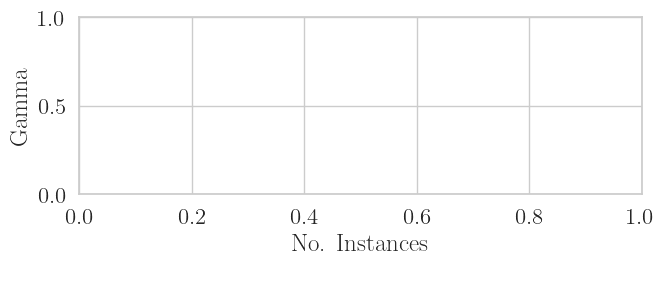

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (7, 3)



fig, ax = plt.subplots()

ax.set_title("")
ax.set_ylabel(r"Gamma")
ax.set_xlabel(r"No. Instances")
# ax.set_ylim([0.0,1])
# sns.lineplot(x=num_instances_to_check, y=gamma_corrs_LAC, ax = ax, marker="o",label="LAC", legend=False)
# sns.lineplot(x=num_instances_to_check, y=gamma_corrs_APS, ax = ax, marker="o",label="APS", legend=False)
# sns.lineplot(x=num_instances_to_check, y=tau_corrs_TopK, ax = ax, marker="o", label="TopK", legend=False)
lgd = fig.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0.08), frameon=False)

fig.tight_layout() 
plt.savefig("replicating.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')
# axes[1].set_title("APS")
# axes[1].set_ylabel(r"Kendalls $\tau$")
# axes[1].set_xlabel(r"No. Pairs")
# sns.lineplot(x=num_pairs_to_check, y=tau_corrs_APS, ax = axes[1])

In [153]:
from math import tau


model_lac = models_LAC[-1]
model_aps = models_APS[-1]

oracle_annotator_lac = OracleAnnotator(generator=clf, score=lac)

oracle_annotator_aps = OracleAnnotator(generator=clf, score=aps)

X_test, y_test = clf.generate_data(1000)
skills_lac = np.take_along_axis(model_lac.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
skills_aps = np.take_along_axis(model_aps.predict_class_skills(X_test), y_test[:,np.newaxis].detach().numpy(), axis=1)
conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


/home/jonas/Documents/Research/torch_plnet/models/ranking_models.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  skills = self.forward(torch.tensor(X, dtype=torch.float32))
/tmp/ipykernel_116313/614543726.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_lac = oracle_annotator_lac.get_conformity(torch.tensor(X_test), torch.tensor(y_test))


In [ ]:
conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
skills = model_lac.predict_class_skills(X_test)
utilities = np.exp(skills)
# utilities = skills
row_sums = utilities.sum(axis=1, keepdims=True)
utilities_normalized = utilities / row_sums
aps_selfmade = aps(-torch.tensor(utilities),torch.tensor(y_test))
goodman_kruskal_gamma(aps_selfmade, conformity_scores_aps)
kendalltau(aps_selfmade, conformity_scores_aps)

/tmp/ipykernel_116313/3617953157.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  conformity_scores_aps = oracle_annotator_aps.get_conformity(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_116313/3617953157.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  aps_selfmade = aps(-torch.tensor(utilities),torch.tensor(y_test))


SignificanceResult(statistic=0.5415167542832982, pvalue=5.618436007965122e-145)

In [144]:
len(np.unique(utilities))

3000

In [150]:
np.max(skills)

12.282402

In [98]:
kendalltau(conformity_scores_aps, skills_aps)

SignificanceResult(statistic=0.4630303030303031, pvalue=8.741007206012674e-12)

Text(0.5, 1.0, 'APS')

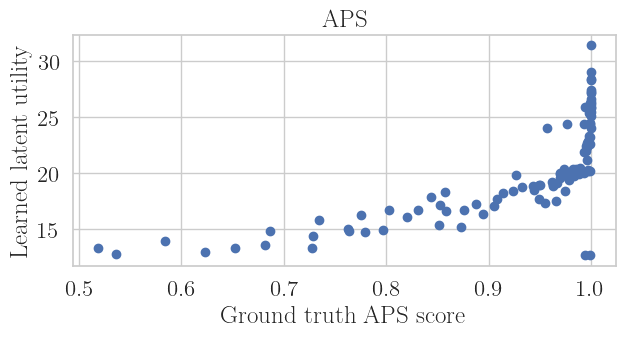

In [83]:
fig,ax = plt.subplots()
ax.scatter(conformity_scores_aps, aps_selfmade)
ax.set_xlabel("Ground truth APS score")
ax.set_ylabel("Learned latent utility")
ax.set_title("APS")

In [152]:
skills_lac.max()

-3.1120312

Text(0.5, 1.0, 'LAC')

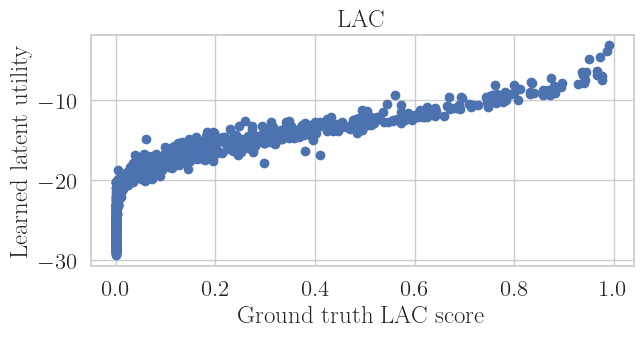

In [132]:
fig,ax = plt.subplots()
ax.scatter(conformity_scores_lac, skills_lac)
ax.set_xlabel("Ground truth LAC score")
ax.set_ylabel("Learned latent utility")
ax.set_title("LAC")

In [137]:
kendalltau(conformity_scores_lac, skills_lac)
np.max(np.exp(skills_lac))

0.044510454

In [138]:
np.min(np.exp(skills_lac))

1.6635756e-13

(array([36., 10., 11.,  5., 12.,  8., 14.,  3.,  0.,  1.]),
 array([1.57008933e-06, 9.59961313e-02, 1.91990693e-01, 2.87985254e-01,
        3.83979815e-01, 4.79974376e-01, 5.75968938e-01, 6.71963499e-01,
        7.67958060e-01, 8.63952621e-01, 9.59947182e-01]),
 <BarContainer object of 10 artists>)

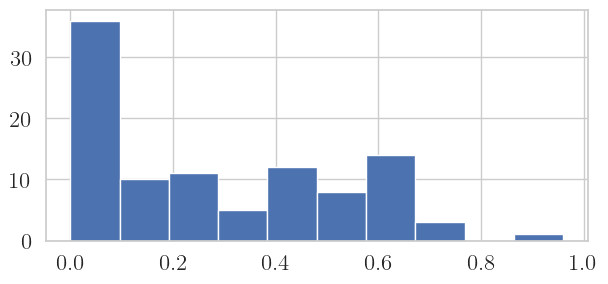

In [13]:
torch.quantile(conformity_scores_aps, q=torch.tensor([0.8]))
from scipy.stats import entropy
plt.hist(entropy(clf.predict_proba(X_test),base=3,axis=1))

(array([36., 10., 11.,  5., 12.,  8., 14.,  3.,  0.,  1.]),
 array([1.57008933e-06, 9.59961313e-02, 1.91990693e-01, 2.87985254e-01,
        3.83979815e-01, 4.79974376e-01, 5.75968938e-01, 6.71963499e-01,
        7.67958060e-01, 8.63952621e-01, 9.59947182e-01]),
 <BarContainer object of 10 artists>)

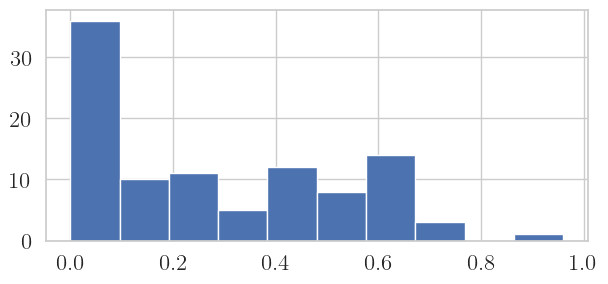

In [14]:
# plt.scatter(conformity_scores, skills_from_model)
from scipy.stats import entropy
probas = clf.predict_proba(X_test)
plt.hist(entropy(probas, base=3, axis=1))

In [28]:

# Initialize and fit the generator
class_params = {
    0: {
        "mean": [3.0, 2.0, 1.0],  # Mean vector for class 0
        "cov": [
            [1.0, 0.5, 0.3],
            [0.5, 1.2, 0.4],
            [0.3, 0.4, 0.8]
        ],  # Covariance matrix for class 0
        "prior": 0.3  # Prior probability for class 0
    },
    1: {
        "mean": [3.0, 4.0, 1.0],  # Mean vector for class 1
        "cov": [
            [1.5, 0.3, 0.2],
            [0.3, 1.1, 0.1],
            [0.2, 0.1, 0.9]
        ],  # Covariance matrix for class 1
        "prior": 0.4  # Prior probability for class 1
    },
    2: {
        "mean": [1.0, 4.0, 4.0],  # Mean vector for class 2
        "cov": [
            [1.2, 0.4, 0.3],
            [0.4, 1.3, 0.5],
            [0.3, 0.5, 1.4]
        ],  # Covariance matrix for class 2
        "prior": 0.3  # Prior probability for class 2
    },
}


clf = TorchMultivariateGaussianClassifier(class_params=class_params, device="cpu")
clf.fit(X_train, y_train)
X_cal, y_cal = clf.generate_data(n_samples=100)

(array([33., 13., 10.,  8.,  7.,  5., 15.,  5.,  3.,  1.]),
 array([5.01720937e-07, 9.51885610e-02, 1.90376620e-01, 2.85564679e-01,
        3.80752739e-01, 4.75940798e-01, 5.71128857e-01, 6.66316917e-01,
        7.61504976e-01, 8.56693035e-01, 9.51881094e-01]),
 <BarContainer object of 10 artists>)

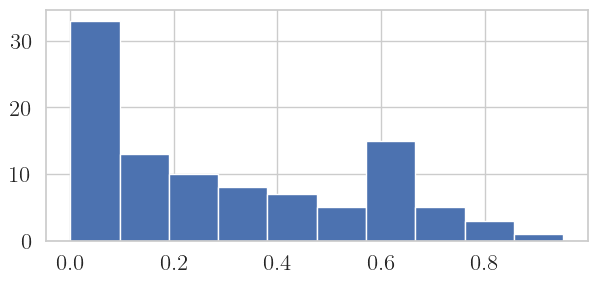

In [29]:
plt.hist(entropy(clf.predict_proba(X_cal),base=3,axis=1))